# Create Custom Transformer

In [1]:
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kaiqu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kaiqu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Kaiqu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

### Implement the StartingVerbExtractor class

In [4]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        # tokenize by sentences
        sentence_list = nltk.sent_tokenize(text)
        
        for sentence in sentence_list:
            # tokenize each sentence into words and tag part of speech
            pos_tags = nltk.pos_tag(tokenize(sentence))

            # index pos_tags to get the first word and part of speech tag
            first_word, first_tag = pos_tags[0]
            
            # return true if the first word is an appropriate verb or RT for retweet
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True

        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        # apply starting_verb function to all values in X
        X_tagged = pd.Series(X).apply(self.starting_verb)

        return pd.DataFrame(X_tagged)

### Run program to test

Labels: ['Action' 'Dialogue' 'Information']
Accuracy:  0.9550748752079867


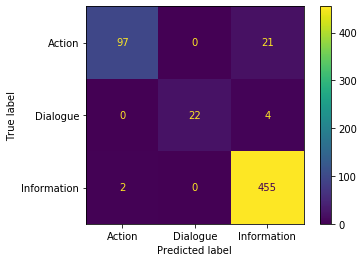

In [5]:
def load_data():
    df = pd.read_csv('../data/corporate_messaging.csv', encoding='latin-1')
    df = df[(df["category:confidence"] == 1) & (df['category'] != 'Exclude')]
    X = df.text.values
    y = df.category.values
    return X, y


def tokenize(text):
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens


def model_pipeline():
    pipeline = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('starting_verb', StartingVerbExtractor())
        ])),

        ('clf', RandomForestClassifier())
    ])

    return pipeline


def display_results(y_test, y_pred, estimator, X_test):
    labels = np.unique(y_pred)
    plot_confusion_matrix(estimator, X_test, y_test, labels=labels)

    print("Labels:", labels)
    print('Accuracy: ', accuracy_score(y_test, y_pred))


def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    model = model_pipeline()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    display_results(y_test, y_pred, model, X_test)

main()